**Contents**
1. Import Libraries and Read Dataset
1. Exploratory Data Analysis
1. Cohort Analysis
    * What is cohort analysis?
    * Cohort Analysis with Python
1. RFM Analysis for Customer Segmentation
    * What is RFM Analysis
    * RFM Analysis with Python
1. K-Means Clustering

## Import Libraries and Read Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import os
print(os.listdir("../input"))

['Online Retail.xlsx']


In [2]:
df = pd.read_excel("../input/Online Retail.xlsx")

## Exploratory Data Analysis

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.001235,-0.00360
UnitPrice,-0.001235,1.000000,-0.00456
CustomerID,-0.003600,-0.004560,1.00000


In [7]:
def monthly(x):
    return dt.datetime(x.year, x.month, 1)

In [8]:
df['BillMonth'] = df['InvoiceDate'].apply(monthly)

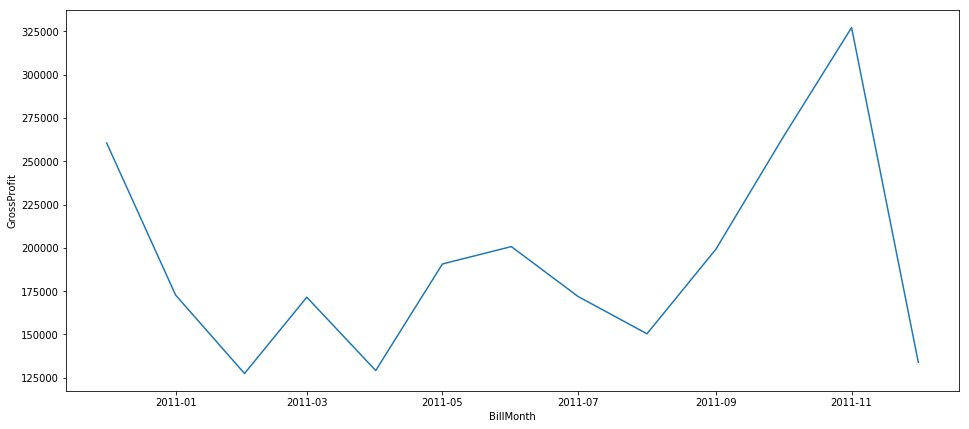

In [9]:
df_sum = df.groupby('BillMonth').sum().drop('CustomerID', axis = 1)
df_sum = df_sum.rename(columns={'UnitPrice' : 'GrossProfit'})

plt.figure(figsize=(16,7))
sns.lineplot(x = df_sum.index, y = df_sum['GrossProfit'])
plt.show()

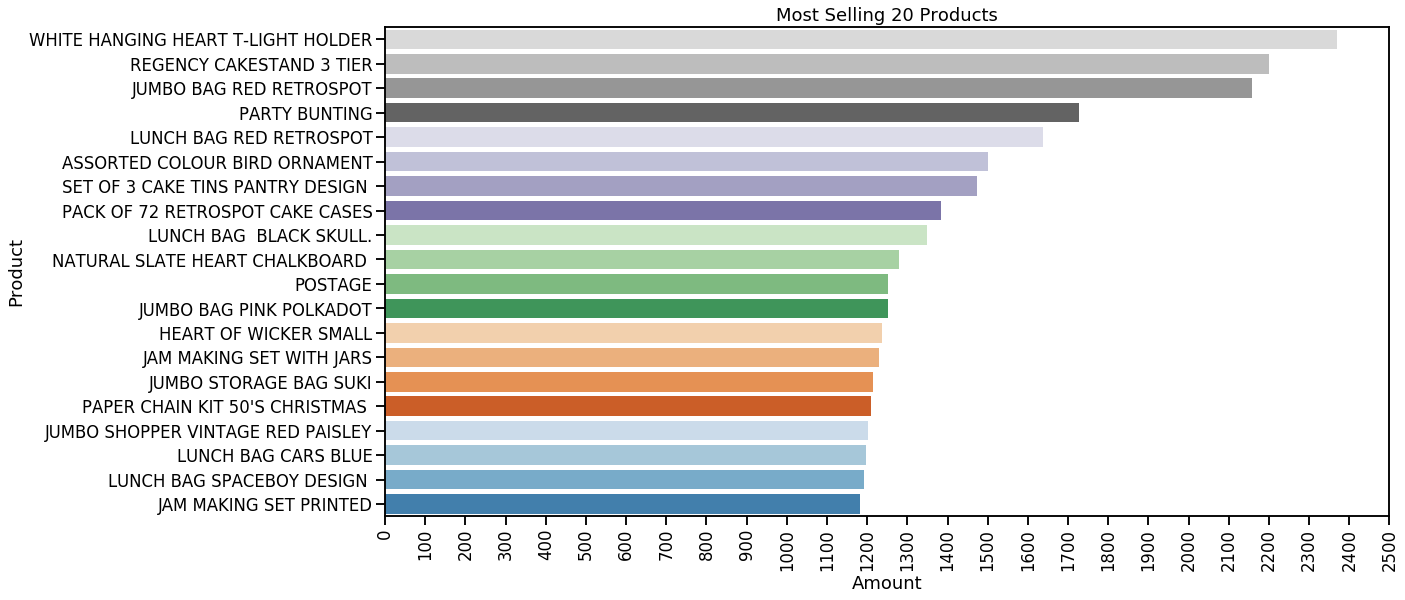

In [10]:
most_selling_products = df['Description'].value_counts()[:20]
plt.figure(figsize = (18,9))
sns.set_context("talk")
sns.barplot(x = most_selling_products.values, y = most_selling_products.index,palette = "tab20c_r")
plt.xticks(np.arange(0,2501,100),rotation = 90)
plt.xlabel("Amount")
plt.ylabel("Product")
plt.title("Most Selling 20 Products")

plt.show()

Data can explore more but I will directly jump into cohort analysis and customer segmentation

## Cohort Analysis

### What is cohort analysis?
<br>
Cohort analysis is a subset of behavioral analytics that takes the data from a given data set and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span. Cohort analysis allows a company to “see patterns clearly across the life-cycle of a customer (or user), rather than slicing across all customers blindly without accounting for the natural cycle that a customer undergoes.” By seeing these patterns of time, a company can adapt and tailor its service to those specific cohorts. While cohort analysis is sometimes associated with a cohort study, they are different and should not be viewed as one and the same. Cohort analysis is specifically the analysis of cohorts in regards to big data and business analytics, while in cohort study, data is broken down into similar groups.
[Wikipedia](https://en.wikipedia.org/wiki/Cohort_analysis)
<br>
![](https://cdn-images-1.medium.com/max/1600/0*Rw-Ikx_Qe4q6EAC3.)

### Cohort Analysis with Python

In [11]:
g = df.groupby('CustomerID')['BillMonth']
df['CohortMonth'] = g.transform('min')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,BillMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [12]:
def get_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [13]:
billYear, billMonth = get_int(df, 'BillMonth')
cohortYear, cohortMonth = get_int(df, 'CohortMonth')

In [14]:
diffYear = billYear - cohortYear
diffMonth = billMonth - cohortMonth

In [15]:
df['Month_Index'] = diffYear * 12 + diffMonth + 1

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,BillMonth,CohortMonth,Month_Index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


In [17]:
df['CohortMonth'] = df['CohortMonth'].apply(dt.datetime.date)

In [18]:
g = df.groupby(['CohortMonth', 'Month_Index'])

In [19]:
cohortData = g['CustomerID'].apply(pd.Series.nunique).reset_index()
cohortCounts = cohortData.pivot(index = 'CohortMonth', columns = 'Month_Index', values = 'CustomerID')
cohortSizes = cohortCounts.iloc[:, 0]
retention = cohortCounts.divide(cohortSizes, axis = 0) * 100

In [20]:
retention.round(2)

Month_Index,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.19,33.44,38.71,35.97,39.66,37.97,35.44,35.44,39.45,37.34,50.00,27.43
2011-01-01,100.0,23.99,28.27,24.23,32.78,29.93,26.13,25.65,31.12,34.68,36.82,14.96,NaN
2011-02-01,100.0,24.74,19.21,27.89,26.84,24.74,25.53,28.16,25.79,31.32,9.21,NaN,NaN
2011-03-01,100.0,19.09,25.45,21.82,23.18,17.73,26.36,23.86,28.86,8.86,NaN,NaN,NaN
2011-04-01,100.0,22.74,22.07,21.07,20.74,23.75,23.08,26.09,8.36,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.66,17.20,17.20,21.51,24.37,26.52,10.39,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.85,18.72,27.23,24.68,33.62,10.21,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.94,20.42,23.04,27.23,11.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.15,25.15,25.15,13.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


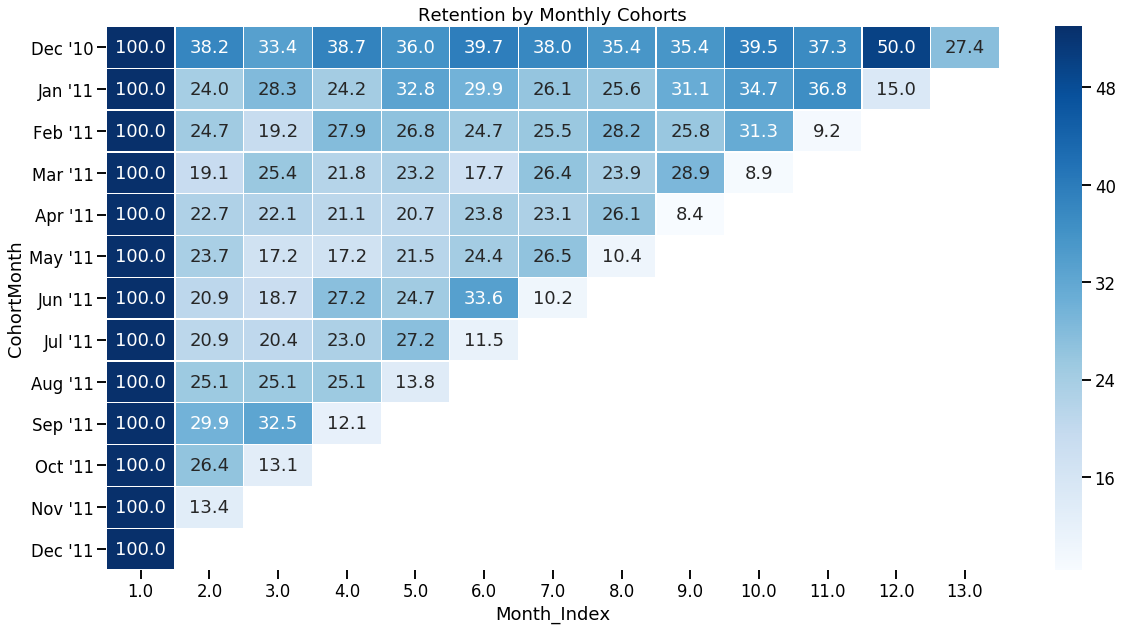

In [21]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11", "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", "Oct '11", "Nov '11", "Dec '11"]
plt.figure(figsize = (20,10))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention.round(2), annot = True, cmap = "Blues", vmax = list(retention.max().sort_values(ascending = False))[1]+3, fmt = '.1f', linewidth = 0.3, yticklabels=month_list)
plt.show()

## RFM Analysis for Customer Segmentation

### What is RFM analysis?

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.
<br>[more](https://clevertap.com/blog/rfm-analysis/)
<br>
![](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

**Calculate RFM values** <br>
Let's calculate recency, frequency and monetary values. Also we will assume that we want cluster our customers into 5 segments.

In [22]:
calculating_date = max(df.InvoiceDate) + dt.timedelta(days = 1) # We assume that we are doing this analysis 1 day after from latest transaction on the data.

In [23]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [24]:
data = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (calculating_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

data.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [25]:
recency_labels = range(5, 0, -1)
frequency_labels = range(1, 6)

recency_groups = pd.qcut(data['Recency'], q=5, labels=recency_labels)
frequency_groups = pd.qcut(data['Frequency'], q=5, labels=frequency_labels)

data = data.assign(R=recency_groups.values, F=frequency_groups.values)

In [26]:
monetary_labels = range(1, 6)
monetary_groups = pd.qcut(data['MonetaryValue'], q=5, labels=monetary_labels)

data = data.assign(M=monetary_groups)

data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data['RFM_Score'].head()

CustomerID
12346.0     3.0
12347.0    15.0
12348.0     9.0
12349.0    12.0
12350.0     5.0
Name: RFM_Score, dtype: float64

In [27]:
def rfm_level(df):
    if df['RFM_Score'] >= 14:
        return 'Platinum Plus'
    elif ((df['RFM_Score'] >= 11) and (df['RFM_Score'] < 14)):
        return 'Platinum'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
        return 'Gold'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8)):
        return 'Silver'
    else:
        return 'Bronze'

data['RFM_Level'] = data.apply(rfm_level, axis=1)

data.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,3.0,Bronze
12347.0,2,182,4310.00,5,5,5,15.0,Platinum Plus
12348.0,75,31,1797.24,2,3,4,9.0,Gold
12349.0,19,73,1757.55,4,4,4,12.0,Platinum
12350.0,310,17,334.40,1,2,2,5.0,Bronze


In [28]:
rfm_level_agg = data.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

rfm_level_agg

Recency Frequency MonetaryValue      
                 mean      mean          mean count
RFM_Level                                          
Bronze          218.2      11.7         187.4   905
Gold             71.3      48.7         857.2  1106
Platinum         33.0     113.8        1977.9   993
Platinum Plus     9.6     345.5        8037.9   612
Silver          115.7      23.7         395.7   756

## K-Means Clustering

Now we will try to cluster our customers with one of the most used clustering ML algorithm: K-Means! But before do that we have to know some details about K-Means. K-Means assumes your variables have symmetric distributions, they have same average values and same variance. So, we will prepare our data according to this assumptions. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


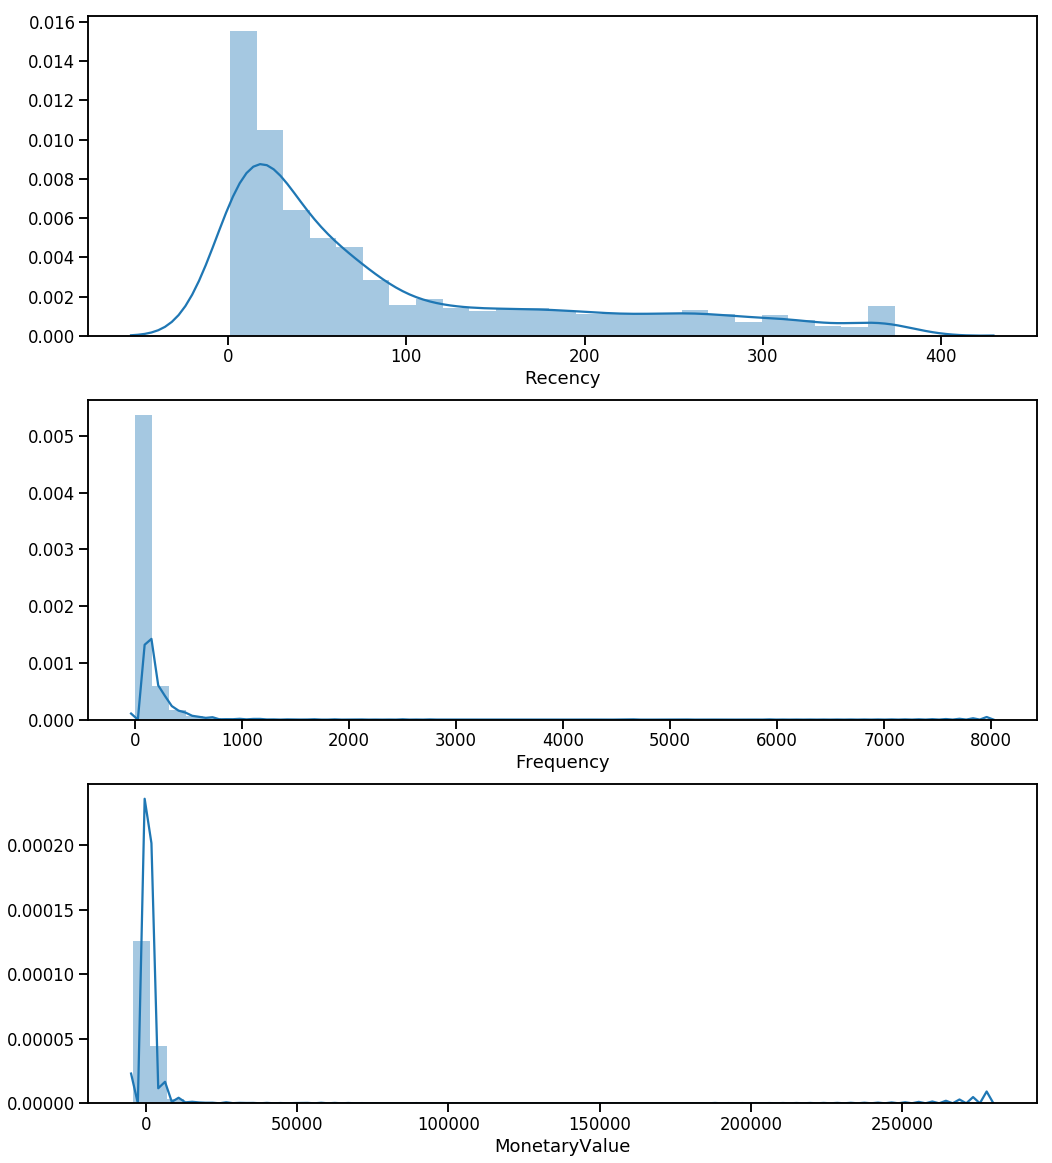

In [29]:
data_rfm = data[['Recency', 'Frequency', 'MonetaryValue']]

plt.figure(figsize = (17,20))
plt.subplot(3, 1, 1); sns.distplot(data_rfm['Recency'])
plt.subplot(3, 1, 2); sns.distplot(data_rfm['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(data_rfm['MonetaryValue'])
plt.show()

In [30]:
data_rfm.min()

Recency             1.00
Frequency           1.00
MonetaryValue   -4287.63
dtype: float64

Since we will apply log transformation we have to make all values positive.

In [31]:
data_rfm_positive = data_rfm
data_rfm_positive.MonetaryValue = data_rfm.MonetaryValue + abs(data_rfm.MonetaryValue.min()) + 1

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [32]:
data_rfm_positive.min()

Recency          1.0
Frequency        1.0
MonetaryValue    1.0
dtype: float64

In [33]:
from sklearn.preprocessing import StandardScaler

data_log = np.log(data_rfm)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data=data_normalized, index=data_rfm.index, columns=data_rfm.columns)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


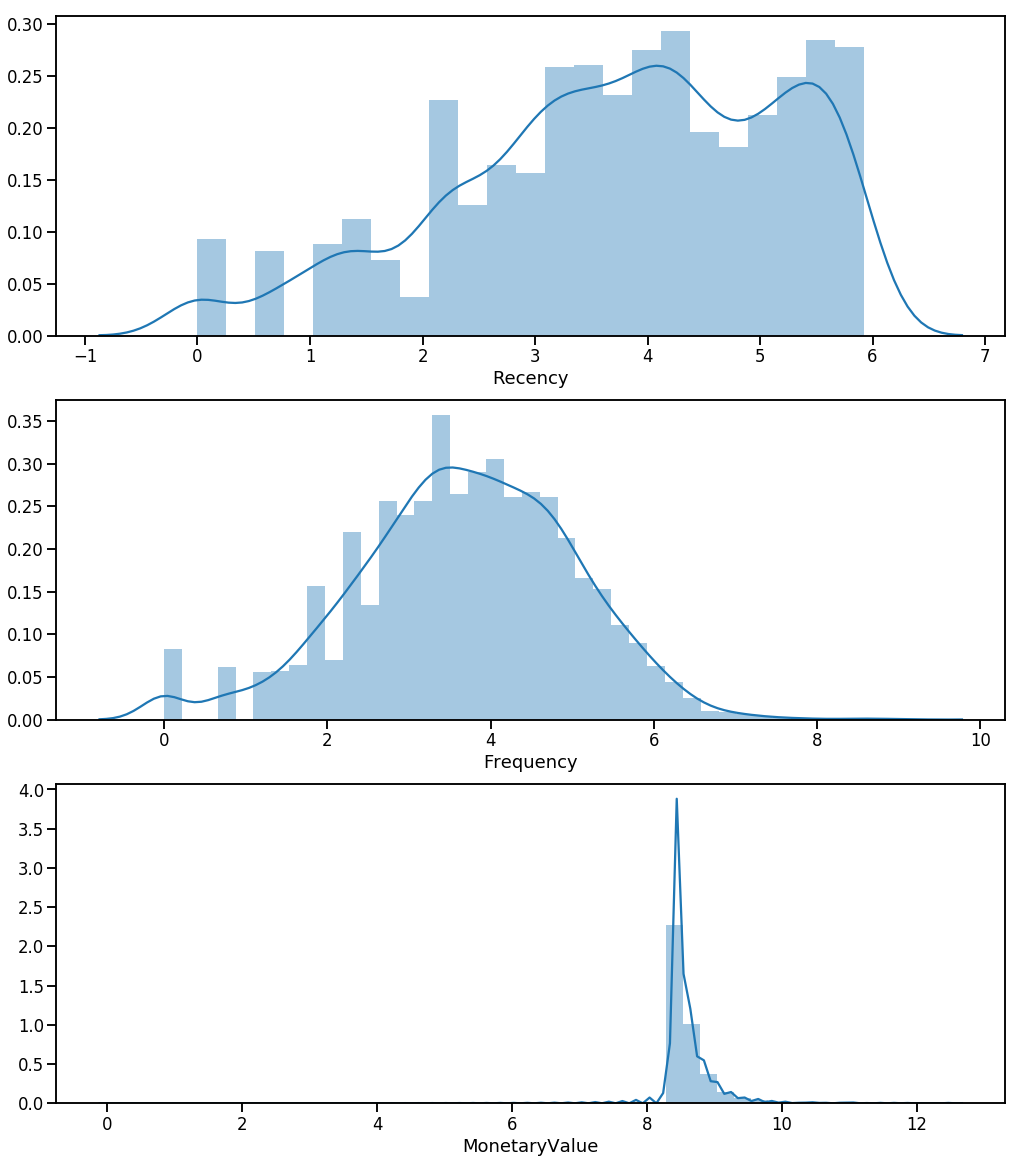

In [34]:
plt.figure(figsize = (17,20))
plt.subplot(3, 1, 1); sns.distplot(data_log['Recency'])
plt.subplot(3, 1, 2); sns.distplot(data_log['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(data_log['MonetaryValue'])
plt.show()

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

In [36]:
data_rfm_k5 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k5.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0           9.9     815.2       42459.2    77
1          14.7      52.1        5086.9   938
2         107.7      69.6        5312.2  1405
3         183.3      11.4        4577.3  1229
4          15.6     253.7        8187.9   723

To find which 'k' value is more suitable for our data we will use elbow method.

In [37]:
sse = {}
for k in range(1, 21):  
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_ 

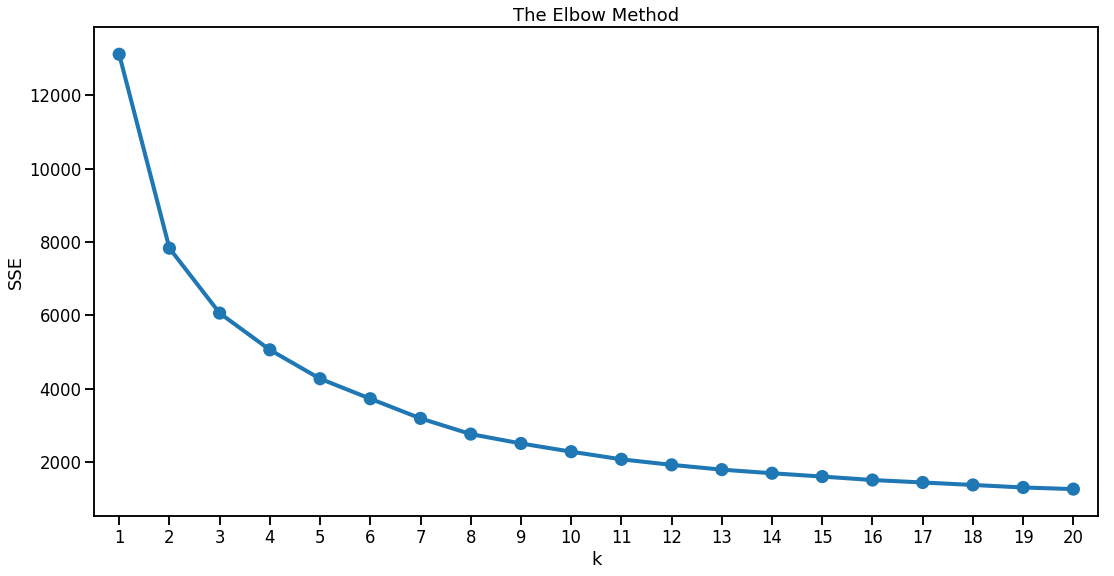

In [38]:
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We can say 3 is the best k value.

In [39]:
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_
data_rfm_k3 = data_rfm.assign(Cluster=cluster_labels)
grouped = data_rfm_k3.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          33.4      97.9        5647.5  1912
1         163.1      22.1        4718.3  2042
2          13.1     417.6       15830.2   418

In [40]:
data_melt = pd.melt(
                    data_rfm_k3.reset_index(),               
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                    var_name='Metric', value_name='Value'
                    )

In [41]:
data_melt.head(10)

,CustomerID,Cluster,Metric,Value
0,12346.0,1,Recency,326.0
1,12347.0,2,Recency,2.0
2,12348.0,1,Recency,75.0
3,12349.0,0,Recency,19.0
4,12350.0,1,Recency,310.0
5,12352.0,0,Recency,36.0
6,12353.0,1,Recency,204.0
7,12354.0,1,Recency,232.0
8,12355.0,1,Recency,214.0
9,12356.0,0,Recency,23.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


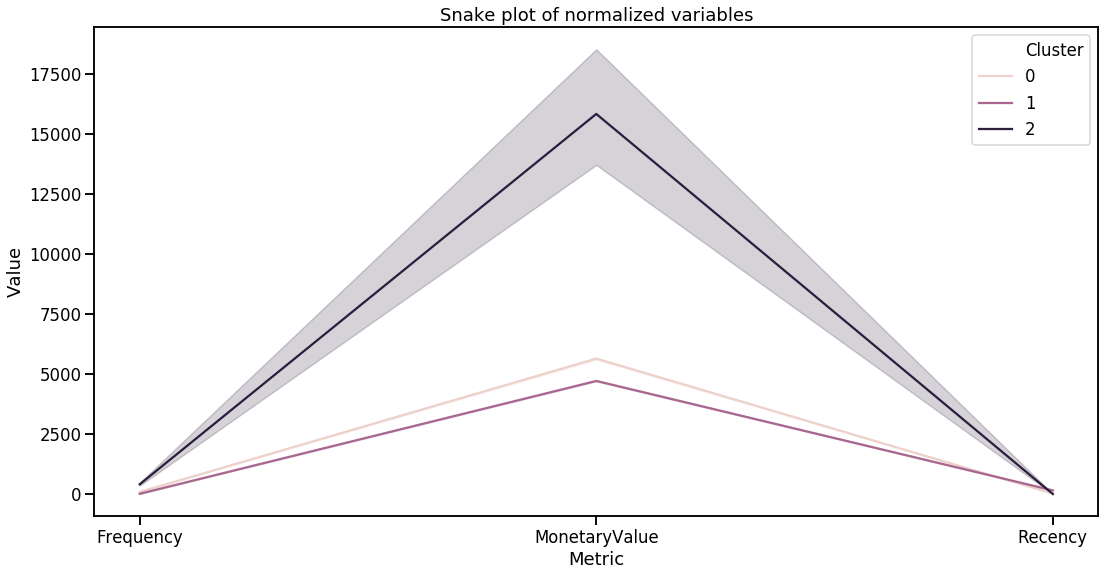

In [42]:
# Snake Plot
plt.figure(figsize = (18,9))
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

**Calculate relative importance of each attribute**<br>
Now we will calculate the relative importance of the RFM values within each cluster.

In [43]:
cluster_avg = data_rfm_k3.groupby(['Cluster']).mean() 
population_avg = data_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.64,0.05,-0.09
1,0.77,-0.76,-0.24
2,-0.86,3.49,1.56


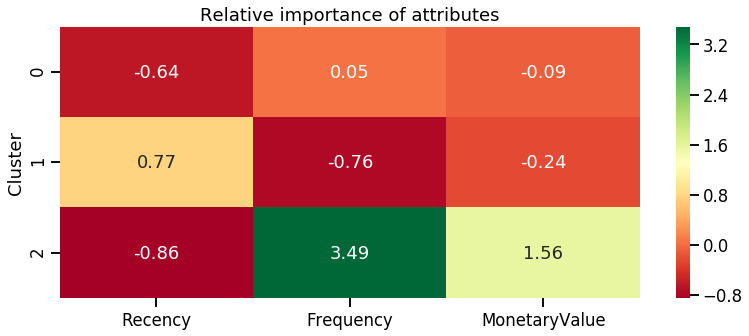

In [44]:
plt.figure(figsize=(13, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [45]:
relative_imp.style.background_gradient(cmap='RdYlGn',axis=1)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.637181,0.0522438,-0.0872044
1,0.772194,-0.762808,-0.237393
2,-0.857728,3.48747,1.55859


### Tenure

In [46]:
tenure_list = []
for i in list(data_rfm.index):
    tenure_list.append((df.InvoiceDate.max() - df[(df.CustomerID == i)]['InvoiceDate'].min()).days + 1)

In [47]:
data_rfmt = data_rfm.assign(Tenure = tenure_list)
data_rfmt.min()

Recency          1.0
Frequency        1.0
MonetaryValue    1.0
Tenure           1.0
dtype: float64

In [48]:
data_rfmt_log = np.log(data_rfmt)
scaler = StandardScaler()
scaler.fit(data_rfmt_log)
data_rfmt_normalized = scaler.transform(data_rfmt_log)

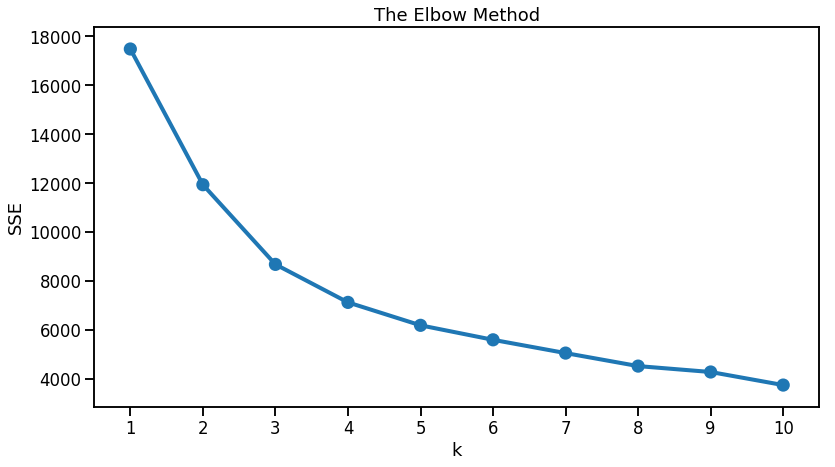

In [49]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_rfmt_normalized)
    sse[k] = kmeans.inertia_ 

plt.figure(figsize = (13,7))
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

3 or 4 ? I'll go with 4.

In [50]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(data_rfmt_normalized)
cluster_labels = kmeans.labels_

In [51]:
data_rfmt_k4 = data_rfmt.assign(Cluster=cluster_labels)
grouped = data_rfmt_k4.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          34.9      35.7        4808.2   50.2   936
1         192.4      24.7        4748.9  257.8  1634
2          11.7     478.0       19098.7  341.7   292
3          34.4     128.1        6101.3  277.6  1510